# 배치

https://developers.google.com/optimization/assignment/assignment_example 와 재연학생이 짠 코드를 참고하여 만들었습니다.  


### OSRM 호출 결과 설명 

- code : Ok (요청이 예상대로 처리)
- routes
    - geometry : route shaply 정보
    - legs : route inf
        - step : 사용된 두 주요 도로의 이름, 경로가 너무 짧은 경우 비어 있을 수 있음
        - distance : 총 거리 (단위 - meter)
        - duration : 총 시간 (단위- 초)
        - summary : 경로 요약
        - weight : 총 시간 (단위)
    - distance : 총 거리 (단위 - meter)
    - duration : 총 시간 (단위)
    - weight_name : routability
    - weight : 총 시간 (단위)
- waypoints : ????
    - hint : 고유 내부 식별자
    - distance : 
    - name : 도로 이름 
    - hint : 고유 내부 식별자
    - distance : 0 
    - name : NULL
    - location : POINT

### 1. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import itertools
import warnings 
import polyline
import requests
import json
import math
from shapely.geometry import Point
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from ortools.linear_solver import pywraplp
from IPython.display import clear_output
import matplotlib.pyplot as plt
from itertools import repeat
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
taxi_locations = pd.read_pickle('data/taxi_locations.pkl')
passenger_locations = pd.read_pickle('data/passenger_locations.pkl')

---
### 2. 전처리

> 차량 타입 = 대형승용, 중형승용(개인택시) : 0(비휠체어), 중형승합 : 1(휠체어)

> 고객 타입 = 0(비휠체어 20%), 1(휄체어80%) 

-  승객 생성할 때 시간 값을 분단위로 바꾸어 줌.  
- 시간 *60 + 분으로 계산했으며 따라서 1일은 0분 ~ 1440분까지의 정수값으로 표현됨  

In [3]:
#차량 분류 변경 -> 휠체어 탑승 불 가능 : 0, 휠체어 탑습 가능 : 1 
def cartype_transform(ps_loc_data):
    cartype_dict = {"대형승용": 0, "중형승용": 0, "증형승용": 0, "중형승합": 1}

    ps_loc_data["cartype"] = list(map(lambda data: data.replace(" ", ""), ps_loc_data.cartype))
    ps_loc_data["cartype"] = [cartype_dict[i] for i in ps_loc_data.cartype]
    return ps_loc_data

#차량 ID 변경 0~547
def change_taxi_id(ps_loc_data):
    change_ID = {i:idx for idx,i in enumerate(set(ps_loc_data.no))}

    ps_loc_data["no"] = [change_ID[i] for i in ps_loc_data["no"]]
    return ps_loc_data

#고객 타입 부여 (0 : 비휠체어, 1 : 휠체어)
def add_passenger_type(ps_loc_data):
    np.random.seed(1205)
    passenger_type_data = np.random.choice(2 ,size = len(passenger_locations), p=[0.2, 0.8])
    ps_loc_data["passenger_type"] = passenger_type_data
    return ps_loc_data

passenger_locations = cartype_transform(passenger_locations)
passenger_locations = change_taxi_id(passenger_locations)
passenger_locations = add_passenger_type(passenger_locations)

In [4]:
#시간 변환 함수 (0~1440분)
def time_transform(ps_loc_data):
    # 배차는 매 분마다 수행이 되도록
    # 매초단위로 수행할 경우 최적화를 돌리는게 큰 의미가 없음
    passenger_df = ps_loc_data[['no', 
                                'cartype',
                                'passenger_type',
                                'settime_date',
                                'settime_time',
                                'receipttime_date',
                                'receipttime_time',
                                'start_point',
                                'end_point']].copy()
    
    #택시 잡힌 시간
    settime_date = pd.to_datetime(passenger_df["settime_date"], format = '%Y-%m-%d')
    settime_date = list(map(lambda data: data.day, settime_date))
    settime_time = pd.to_datetime(passenger_df['settime_time'], format='%H:%M:%S')
    
    #콜 접수 시간
    receipttime_date = pd.to_datetime(passenger_df['receipttime_date'], format='%Y-%m-%d')
    receipttime_date = list(map(lambda data: data.day, receipttime_date))
    receipttime_time = pd.to_datetime(passenger_df['receipttime_time'], format='%H:%M:%S')
    
    #시분초 -> 0~1440분으로 변환
    set_time = settime_time.dt.minute + settime_time.dt.hour*60
    set_time = set_time.tolist()
    
    receipt_time = receipttime_time.dt.minute + receipttime_time.dt.hour*60
    receipt_time = receipt_time.tolist()
    
    passenger_df['time'] = [t+1440 if d == 17 else t for t,d in zip(receipt_time, receipttime_date)]
    passenger_df['set_time'] = [t+1440 if d == 17 else t for t,d in zip(set_time, settime_date)]
    
    passenger_df.drop(['settime_date','settime_time','receipttime_date','receipttime_time'], axis=1, inplace=True)
    passenger_df.reset_index(drop=True, inplace=True)
    return passenger_df

passenger_locations = time_transform(passenger_locations)

In [5]:
#택시 운행 정보 데이터
def generate_taxi_inf(ps_loc_data):
    taxi_start_end_dict = dict()
    for i in ps_loc_data.groupby("no"):
        taxi_start_end_dict[i[0]] = {"cartype":i[1]["cartype"].tolist()[0]}
        taxi_start_end_dict[i[0]]["start"] = min(i[1]["set_time"])
        taxi_start_end_dict[i[0]]["end"] = max(i[1]["set_time"])
        taxi_start_end_dict[i[0]]["cnt"] = len(i[1])

    taxi_inf = pd.DataFrame(taxi_start_end_dict.values())
    taxi_inf["no"] = taxi_start_end_dict.keys()
    taxi_inf = taxi_inf[["no", "cartype", "start", "end", "cnt"]]
    taxi_inf["duration"] = taxi_inf["end"] - taxi_inf["start"]
    return taxi_inf

taxi_inf = generate_taxi_inf(passenger_locations)

---

- 시간대 별 첫 운행 시작 분포, 마지막 운행 시작 분포

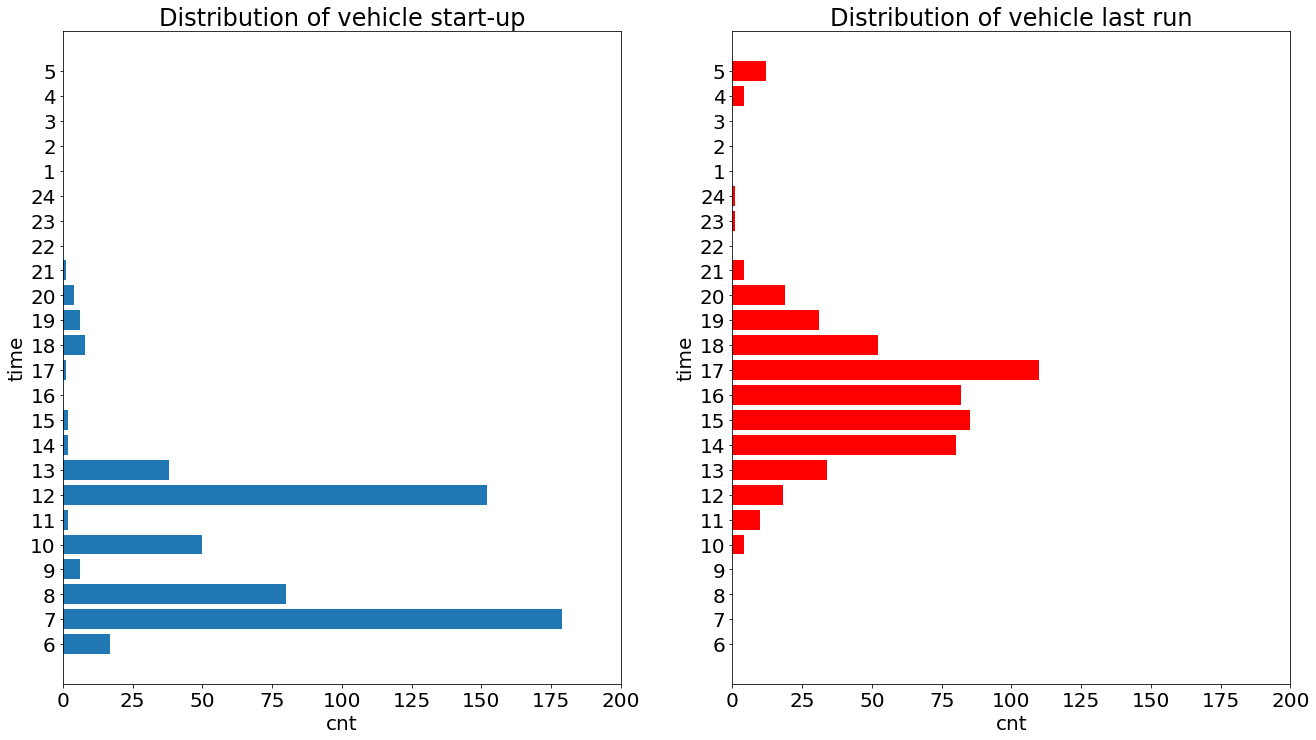

In [11]:
#운행 시작시간
import matplotlib.pyplot as plt

bins = [i*60 for i in range(6,31)]
labels = [f"{i}" for i in range(6,30)]
labels_name = [f"{i}" for i in range(6,25)] + [f"{i}" for i in range(1,6)]

start = pd.DataFrame(pd.cut(taxi_inf["start"], bins, labels = labels).value_counts(sort=False))
end = pd.DataFrame(pd.cut(taxi_inf["end"], bins, labels = labels).value_counts(sort=False))

f, axes = plt.subplots(1, 2)
f.set_size_inches((22, 12))
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기

axes[0].barh(start.index ,start["start"])
axes[0].set_yticklabels(labels_name, fontsize=20)
axes[0].set_xlim(0, 200)
axes[0].set_xlabel("cnt")
axes[0].set_ylabel("time")
axes[0].set_title("Distribution of vehicle start-up")

axes[1].barh(end.index ,end["end"], color = "red")
axes[1].set_yticklabels(labels_name, fontsize=20)
axes[1].set_xlim(0, 200)
axes[1].set_xlabel("cnt")
axes[1].set_ylabel("time")
axes[1].set_title("Distribution of vehicle last run")
plt.show()

- 시간대 별 배차 성공 분포

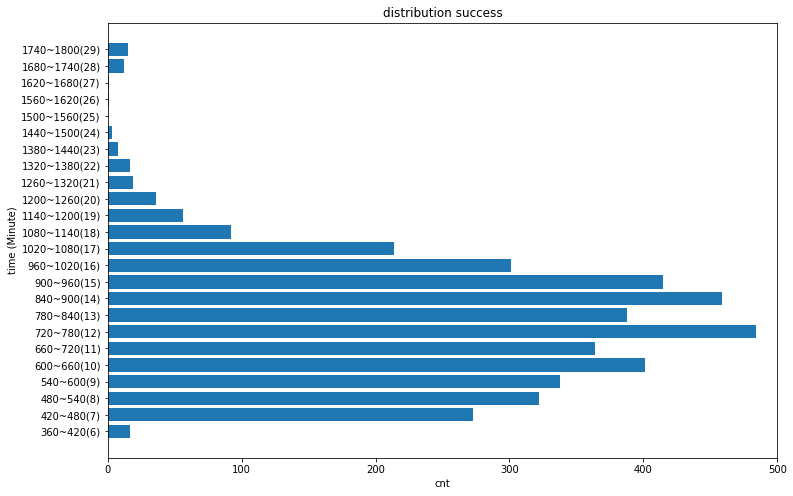

In [7]:
bins = [i*60 for i in range(6,31)]
labels = [f"{(i)*60}~{(i+1)*60}({i})" for i in range(6,30)]

call_cnt_by_time = pd.DataFrame(pd.cut(passenger_locations["set_time"], bins, labels = labels).value_counts(sort=False))

plt.figure(figsize=(12, 8))
plt.barh(call_cnt_by_time.index ,call_cnt_by_time["set_time"])
plt.xlim(0, 500)
plt.xlabel("cnt")
plt.ylabel("time (Minute)")
plt.title("distribution success")
plt.show()

---

- 택시 근무시간 고려 출퇴근시간 임의 지정

In [8]:
def operation_inf(taxi_information):
    #A조 17시 이전 근무자 9시간 근무
    #B조 17시 이후 근무자 12시간 근무 
    bins = [i*60 for i in range(6,31)]
    labels = [i for i in range(6,30)]

    taxi_information["start_time"] = pd.cut(taxi_information["start"], bins, labels = labels)
    
    A = taxi_information.loc[np.array(taxi_information["start_time"].tolist()) < 17]
    B = taxi_information.loc[np.array(taxi_information["start_time"].tolist()) >= 17]
    A["start_time"] = np.array(A.start_time.tolist()) * 60
    B["start_time"] = np.array(B.start_time.tolist()) * 60
    
    A["end_time"] = np.array(A.start_time.tolist()) + (9*60)
    B["end_time"] = np.array(B.start_time.tolist()) + (12*60)
    taxi_information = pd.concat([A,B])
    return taxi_information

taxi_inf = operation_inf(taxi_inf)

In [9]:
taxi_schedule = taxi_inf[["no", "cartype", "start_time", "end_time"]]

taxi_locations["no"] = list(taxi_schedule.no)
taxi_locations = taxi_locations.drop(["Taxi_ID"], axis=1)

taxi_locations = pd.merge(taxi_schedule,taxi_locations)

---

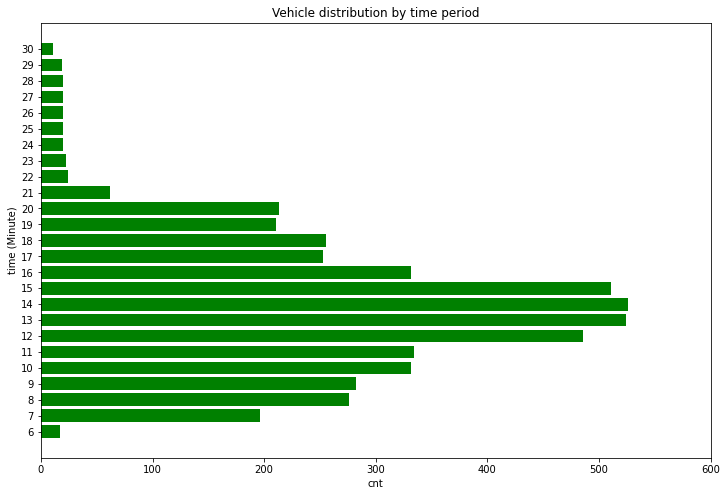

In [10]:
empty_taxi = pd.DataFrame()

virtual_taxi_schedule = []
for i in range(6,31):
    #운행 시작 택시
    start_taxi = taxi_locations.loc[taxi_locations.start_time == i*60]
    empty_taxi = pd.concat([start_taxi, empty_taxi])
    #운행종료 택시 제거
    empty_taxi = empty_taxi.loc[empty_taxi.end_time != i*60]
    virtual_taxi_schedule.append([i ,len(empty_taxi)])
    
virtual_taxi_schedule = pd.DataFrame(virtual_taxi_schedule)
virtual_taxi_schedule.columns = ["time", "cnt"]

plt.figure(figsize=(12, 8))
plt.barh(np.array(virtual_taxi_schedule["time"].tolist()).astype("str") ,virtual_taxi_schedule["cnt"], color = "green")
plt.xlim(0, 600)
plt.xlabel("cnt")
plt.ylabel("time (Minute)")
plt.title("Vehicle distribution by time period")
plt.show()

---

- 승객 route 추가

In [11]:
# 상세한 경로와 시간을 뽑는 함수
# 시간이 많이 걸리기 때문에 최종적으로 시각화 할 때만 사용
def get_res(pickup_point, dropoff_point):
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    steps = "?steps=true"
    loc = "{},{};{},{}".format(pickup_point.x, pickup_point.y, dropoff_point.x, dropoff_point.y)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = session.get(url + loc + steps) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    all_steps = res["routes"][0]["legs"][0]["steps"]
    all_steps = all_steps[:-1]
    return all_steps

def get_part_time(step):
    duration_part = math.ceil((step["duration"] / 60)*100)/100
    location_part = polyline.decode(step["geometry"])
    duration_part = [math.ceil((duration_part/(len(location_part)-1)*100))/100] * (len(location_part) - 1)
    return duration_part

def get_part_route(step):
    location_part = polyline.decode(step["geometry"])
    location_part = list(map(lambda data: [data[1],data[0]] ,location_part))
    return location_part
    
def get_total_route(all_step):
    total_route = list(map(lambda data: get_part_route(data), all_step))
    last_location = total_route[-1][-1]
    total_route = list(map(lambda data: data[:-1], total_route))
    total_route = list(itertools.chain(*total_route))
    total_route.append(last_location)
    return total_route

def get_total_time(all_step):
    total_time = list(map(lambda data: get_part_time(data), all_step))
    total_time = list(itertools.chain(*total_time))
    total_time = list(itertools.accumulate(total_time)) 
    start_time = [0]
    start_time.extend(total_time)
    total_time = start_time
    return total_time 


def get_route_time_dataframe(data_frame):
    total_all_steps = list(map(lambda data: get_res(data[1]["start_point"], data[1]["end_point"]), data_frame.iterrows())) 
    total_all_route = list(map(lambda data: get_total_route(data), total_all_steps))
    total_all_time = list(map(lambda data: get_total_time(data), total_all_steps))
    data_frame["route"] = total_all_route 
    data_frame["timestamp"] = total_all_time
    return data_frame 

passenger_locations = get_route_time_dataframe(passenger_locations)

In [12]:
#승객과 택시의 정보가 혼동되지 않게 컬럼명 변경 ps_loc_0 : 승객 승차 위치, ps_loc_1 : 승객 하차 위치 
def redefine_col_name(ps_loc_data, taxi_loc_data): 
    #cartype, passenger_type, ps_location_0, ps_location_1, call_time, ps_route, ps_timestamp
    ps_loc_data.columns = ['no', 'cartype', 'ps_type', 'ps_loc_0', 'ps_loc_1', 'call_time', 'set_time', 'ps_route', 'ps_timestamp']
    ps_loc_data = ps_loc_data[['ps_type', 'ps_loc_0', 'ps_loc_1', 'call_time', 'ps_route', 'ps_timestamp']]
    #no, cartype, work_start, work_end, boarding_status, tx_location
    taxi_loc_data.columns = ['no', 'cartype', 'work_start', 'work_end', 'board_status', 'tx_loc']
    taxi_loc_data = taxi_loc_data[['no', 'cartype', 'work_start', 'work_end', 'board_status', 'tx_loc']]
    return ps_loc_data, taxi_loc_data

passenger_locations, taxi_locations = redefine_col_name(passenger_locations, taxi_locations)
passenger_locations["wait_time"] = 0

전처리 결과
- 사용 데이터 : passenger_locations, taxi_locations, taxi_schedule
- 처리 내용 
    - 편의를 위한 택시 ID(컬럼명:no) 0~ 547로 변경
    - 시간 : 00:01:00 -> 1440분으로 변경 
    - 택시 근무 시간 지정 (현재 운영 체계 고려)
    - 미사용 컬럼 제거 및 컬럼명 혼동 방지를 위한 변경
---

### 3. 최적화를 통한 Dispatch 수행 알고리즘 
- 차량 배차 
- 고객한테 가는 route 뽑기 (차량에 전달)

In [13]:
###costs 뽑는 과정 (각 차량과 승객의 직선 거리를 모두 구함)
def haversine(lat1, lon1, lat2, lon2):
    km_constant = 3959* 1.609344
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = km_constant * c
    return km

#costs 
def get_taxi_meter(ps_loc_data, taxi_loc_data):
    return list(map(lambda data: haversine(data.y, data.x, taxi_loc_data.y, taxi_loc_data.x).tolist(), ps_loc_data))

############################################################################################################
### 배차 알고리즘
def dispatch(passenger_location_data, taxi_locaton_data, cost_matrix):
    #Calculate cost matrix
    # 모든 빈택시와 모든 승객들에 대해서 각각의 통행시간을 계산
    passenger_cnt = len(passenger_location_data)
    taxi_cnt = len(taxi_locaton_data)
    
    #Declare the MIP solver
    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')

    taxi_idx = sorted(list(itertools.chain(*list(repeat(list(range(taxi_cnt)), passenger_cnt)))))
    passenger_idx = list(itertools.chain(*list(repeat(list(range(passenger_cnt)), taxi_cnt))))

    #Create the variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for t, p in zip(taxi_idx, passenger_idx):
        x[t, p] = solver.IntVar(0, 1, '')
        
    #Create the constraints
    #Each worker is assigned to at most 1 task.
    for i in range(taxi_cnt):
        solver.Add(solver.Sum([x[i, j] for j in range(passenger_cnt)]) <= 1)

    # Each task is assigned to exactly one worker.
    for j in range(passenger_cnt):
        solver.Add(solver.Sum([x[i, j] for i in range(taxi_cnt)]) == 1)
        
    #Create the objective function
    objective_terms = []
    for i in range(taxi_cnt):
        for j in range(passenger_cnt):
            objective_terms.append(cost_matrix[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))
    #Invoke the solver
    status = solver.Solve()
    # Print solution
    taxi_iloc = []
    passenger_iloc = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        #print('Total distance = ', solver.Objective().Value(), '\n')
        for i in range(taxi_cnt):
            for j in range(passenger_cnt):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    #print('taxi %d assigned to passenger %d.  duration(s) = %d' %
                    #    (i, j, cost_matrix[i][j]))  
                    taxi_iloc.append(i) 
                    passenger_iloc.append(j)
    return taxi_iloc, passenger_iloc

# main 배차 함수
def main_dispatch(ps_loc_data, taxi_loc_data):
    costs = list(map(lambda data: get_taxi_meter(ps_loc_data.ps_loc_0, data), taxi_loc_data.tx_loc))
    taxi_iloc, passenger_iloc = dispatch(ps_loc_data, taxi_loc_data, costs)
    return taxi_iloc, passenger_iloc

- 1단계
    - dispath 시 휠체어 가능 차량 (휠체어 가능 택시 매칭)
    - 현재 차량 운행 대수가 모자르면 손님 랜덤 자르고 배차 (한 번 콜 팅기면 다음 배차 우선순위)

---

### 4. Dispatch 실행

- 휠체어 가능과 휠체어 고객 매칭 고려 
- 시간별 차량 운행 시간 고려 
- 차량 부족으로 콜 시간에 매칭 고객 먼저 배차

---
- 현재 배차 시스템 
    - 접수하신 순서, 기다리신 시간, 차량과의 거리로 산정된 점수에 따라 실거리 7km 이내 빈 차량이 있을 경우 순차적으로 연결
    - 접수순서 20점 + 대기시간 40점 + 거리 30점 합산 후 차량 배차

- endpoint 좌표
- 차량 탑승시간 고려
- 탑승 완료 waiting 시간 기록 

In [14]:
# 좌표 기반 라우팅 데이터 반환 함수 만들기
def get_route_time_locations(start_point, end_point):
    all_steps = get_res(start_point, end_point)
    all_route = get_total_route(all_steps)
    all_time = get_total_time(all_steps)
    return all_route, all_time

#휠체어 탑승자는 휠체어 가능 차량만 배차
def dispath_and_add_rt_tt(call_data, taxi_data):
    taxi_iloc, passenger_iloc = main_dispatch(call_data, taxi_data)
    
    #남은 차량 또는 남은 승객
    remain_taxi_mask = list(set(range(len(taxi_data))) - set(taxi_iloc))
    remain_ps_mask = list(set(range(len(call_data))) - set(passenger_iloc))
        
    remain_taxi = taxi_data.iloc[remain_taxi_mask]
    remain_ps = call_data.iloc[remain_ps_mask]
    
    #배차 성공 차량 또는 승객 
    success_taxi = taxi_data.iloc[taxi_iloc]
    
    success_ps = call_data.iloc[passenger_iloc]
    success_ps["no"] = success_taxi["no"].tolist()
    
    success = pd.merge(success_taxi, success_ps)
    
    #택시와 승객 route, timestamp 추가
    success_route_time = list(map(lambda data: get_route_time_locations(data[1]["tx_loc"], data[1]["ps_loc_0"]) ,success.iterrows()))
    success["to_ps_route"] = [i[0] for i in success_route_time]
    success["to_ps_timestamp"] = [i[1] for i in success_route_time]
    
    #해당 시간으로 더해주기
    success["ps_timestamp"] =  list(map(lambda data: (np.array(data[1]["ps_timestamp"]) + np.array([data[1]["to_ps_timestamp"][-1] + max(success.call_time)])).tolist() , success.iterrows()))
    success["to_ps_timestamp"] =  list(map(lambda data: (np.array(data[1]["to_ps_timestamp"]) + np.array([max(success.call_time)])).tolist() , success.iterrows()))
    success["end_time"] = list(map(lambda data: data[1]["ps_timestamp"][-1] , success.iterrows()))
 
    return success, [remain_taxi, remain_ps]

In [15]:
def make_json_and_taxi_data(taxi_data):
    to_ps_taxi =  taxi_data[["board_status","to_ps_route","to_ps_timestamp"]]
    to_ps_taxi.columns = ["vendor", "path", "timestamps"]
    to_ps_taxi = list(to_ps_taxi.T.to_dict().values())

    taxi_data["board_status"] = 1
    taxi = taxi_data[["board_status", "ps_route", "ps_timestamp"]]
    taxi.columns = ["vendor", "path", "timestamps"]
    taxi = list(taxi.T.to_dict().values())
    taxi_data["board_status"] = 0 
    taxi_data["tx_loc"] = taxi_data["ps_loc_1"]

    to_ps_taxi.extend(taxi)
    taxi_data = taxi_data[['no', 'cartype', 'work_start', 'work_end', 'board_status', "end_time",'tx_loc']]
    return taxi_data, to_ps_taxi

In [16]:
def match_taxi_ps(call_data, taxi_data):
    #휠체어, 비휠체어 승객 데이터 분할
    passenger_call_0 = call_data.loc[call_data["ps_type"] == 0]
    passenger_call_1 = call_data.loc[call_data["ps_type"] == 1]

    #휠체어, 비휠체어 차량 데이터 분할
    taxi_locations_0 = taxi_data.loc[taxi_data["cartype"] == 0]
    taxi_locations_1 = taxi_data.loc[taxi_data["cartype"] == 1]

    ##################################################################################
    ##휠체어 배차
    success_1, remain_1 = dispath_and_add_rt_tt(passenger_call_1, taxi_locations_1)

    ###휠체어 고객 배차 후 데이터 반환
    driving_1, trip_1 = make_json_and_taxi_data(success_1)
    ###################################################################################
    ##비휠체어 고객 배차
    #모든 휠체어 고객 배차 성공 시
    if len(remain_1[1]) == 0:
        #비휄체어 고객 배차
        taxi_remain = pd.concat([remain_1[0], taxi_locations_0])
        success_2, remain_2 = dispath_and_add_rt_tt(passenger_call_0, taxi_remain)
        taxi_remain = remain_2[0]
        
        ###비휠체어 고객 배차 후 데이터 반환
        driving_2, trip_2 = make_json_and_taxi_data(success_2)
        
        if len(remain_2[1]) > 0: 
            passenger_remain = remain_2[1]
        else:
            passenger_remain = pd.DataFrame()
    #차가 없으면 이번 time pass
    elif len(remain_1[1]) > 0: 
        taxi_remain = pd.concat([remain_1[0], taxi_locations_0])
        success_2, remain_2 = dispath_and_add_rt_tt(passenger_call_0, taxi_remain)
        
        ###비휠체어 고객 배차 후 데이터 반환
        driving_2, trip_2 = make_json_and_taxi_data(success_2)    
        passenger_remain = pd.concat([remain_1[1],remain_2[1]])
        taxi_remain = remain_2[0]
        
    trip = trip_1 + trip_2
    driving = pd.concat([driving_1, driving_2])
    return trip, driving, passenger_remain, taxi_remain

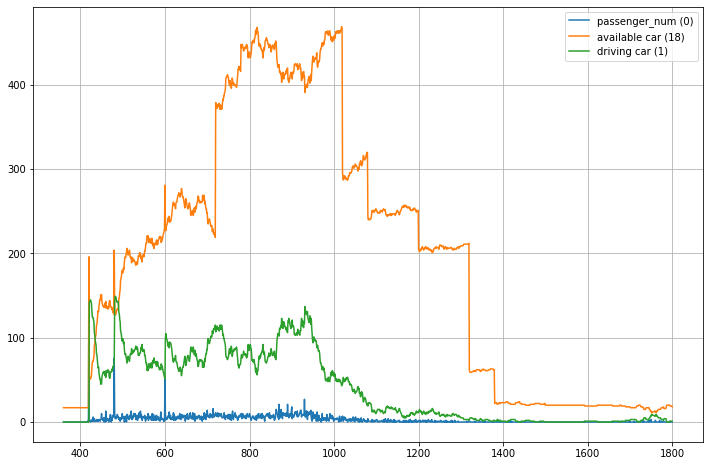

In [17]:
empty_taxi = pd.DataFrame()
driving_data = pd.DataFrame()
ps_remain = []
trips = []

####
a = [] #대기 고객
b = [] #배차 가능 차량 
c = [] #운행 중인 차량
x = [] #시간

et = []
####

for i in range(6*60, 30*60+1):
    clear_output(True)
    #운행종료 택시 제거
    if (i % 60 == 0) and (i != 360):
        empty_taxi = empty_taxi.loc[empty_taxi.work_end >= i]

    if i % 60 == 0:
        #운행 시작 택시
        start_taxi = taxi_locations.loc[taxi_locations.work_start == i]
        #배차 안된 택시
        empty_taxi = pd.concat([start_taxi, empty_taxi])
    #택시 콜한 고객
    call_ps = passenger_locations.loc[passenger_locations.call_time == i]
    
    et.append([i,empty_taxi])
    ###
    a.extend([len(call_ps) + len(ps_remain)])
    b.extend([len(empty_taxi)])
    c.extend([len(driving_data)])
    x.extend([i])
    
    plt.figure(figsize=(12, 8))
    plt.rcParams['axes.grid'] = True 
    plt.plot(x,a, label = f"passenger_num ({len(call_ps) + len(ps_remain)})")
    plt.plot(x,b, label = f"available car ({len(empty_taxi)})")
    plt.plot(x,c, label = f"driving car ({len(driving_data)})")
    plt.legend()
    plt.show()
    ###
    
    if len(call_ps) + len(ps_remain) > 0:
        if len(ps_remain) > 0:
            ps_remain.call_time = i #현재 시간
            
            trip, driving, ps_remain, tx_remain = match_taxi_ps(ps_remain,empty_taxi)

            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            trips.extend(trip)
            
            if len(ps_remain) > 0:
                ps_remain = pd.concat([ps_remain, call_ps])
                
        if len(ps_remain) == 0:
            trip, driving, ps_remain, tx_remain = match_taxi_ps(call_ps, empty_taxi)
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            trips.extend(trip)
    
    if len(driving_data) > 0:
        #################
        #운행 종료 택시
        drive_end = driving_data.loc[driving_data["end_time"] <= i]
        drive_end = drive_end[["no","cartype","work_start","work_end","board_status","tx_loc"]]
        #운행 중인 택시
        driving_data = driving_data.loc[driving_data["end_time"] > i]
        #운행 종료 후 택시 빈 택시에 추가
        empty_taxi = pd.concat([empty_taxi ,drive_end])

In [18]:
def stop_taxi_inf(taxi_min_inf): 
    sub_stop_taxi_inf = pd.DataFrame([taxi_min_inf[1]["no"].values, taxi_min_inf[1]["tx_loc"].values, np.array([taxi_min_inf[0]] * len(taxi_min_inf[1]))]).T
    sub_stop_taxi_inf.columns = ["no", "tx_loc", "time"]
    return sub_stop_taxi_inf

def generate_taxi_pull_over_inf(pull_over_inf):
    taxi_pull_over = []
    while len(pull_over_inf) != 0:
        sub_data= pull_over_inf.loc[pull_over_inf.tx_loc == pull_over_inf.tx_loc.iloc[0]]
        pull_over_inf = pull_over_inf.loc[pull_over_inf.tx_loc != pull_over_inf.tx_loc.iloc[0]]
        if len(sub_data) == 1:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(sub_data.iloc[0]["time"])]}])
        else:
            taxi_pull_over.extend([{"path" :[sub_data.iloc[0]["tx_loc"].x, sub_data.iloc[0]["tx_loc"].y], "timestamp" : [int(min(sub_data["time"])), int(max(sub_data["time"]))]}])
    return taxi_pull_over

In [19]:
stop_taxi = pd.concat(list(map(lambda data: stop_taxi_inf(data), et)))

empty = list(map(lambda data : generate_taxi_pull_over_inf(data[1]) ,stop_taxi.groupby("no")))

empty = list(itertools.chain(*empty))

In [20]:
file_path = "empty.json"

with open(file_path, "w") as f:
    json.dump(empty, f)

In [21]:
file_path = "trips.json"

with open(file_path, "w") as f:
    json.dump(trips, f)